In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/My Drive/P1_Facial_Keypoints

/content/drive/My Drive/P1_Facial_Keypoints


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

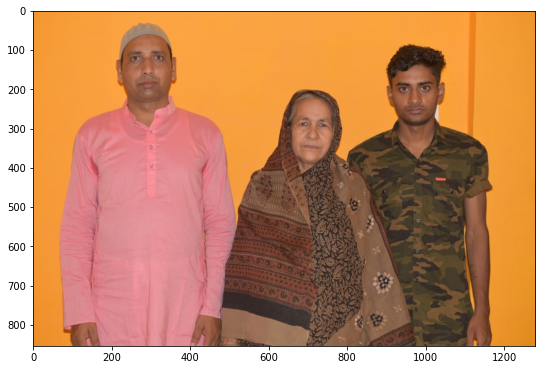

In [26]:
import cv2
# load in color image for face detection
image_1 = cv2.imread('images/fam.jpg')
image_2 = cv2.imread('images/friend3.jpg')
# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

images = [image_1, image_2]

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(images[0])

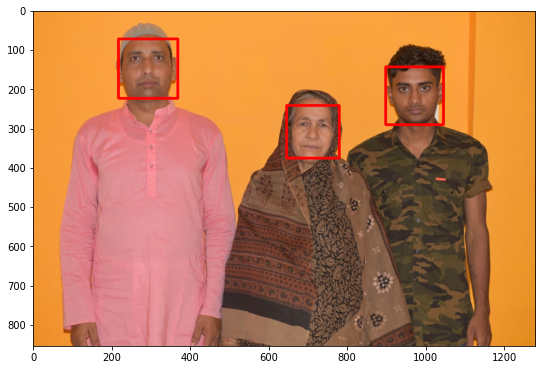

In [27]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')


# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image

faces_list = []
images_with_detections = []
# make a copy of the original image to plot detections on
for image in images:
    faces_list.append(face_cascade.detectMultiScale(image, 1.3, 5))
    images_with_detections.append(image.copy())

for i, faces in enumerate(faces_list):
    # loop over the detected faces, mark the image where each face is found
    
    rec_thickness = images_with_detections[i].shape[0]//150
    for (x,y,w,h) in faces:
        # draw a rectangle around each detected face
        # you may also need to change the width of the rectangle drawn depending on image resolution
        cv2.rectangle(images_with_detections[i],(x,y),(x+w,y+h),(255,0,0),rec_thickness) 
        
fig = plt.figure(figsize=(9,9))

plt.imshow(images_with_detections[0])

In [ ]:

import torch
from models import resnet18_grayscale

img_size = 224

#net = NaimishNet(image_size=img_size, kernels=[5, 5, 5, 5], use_maxp=False)
resnet18 = resnet18_grayscale()

## load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
model_dir = 'saved_models/'
model_name = 'resnet18_gray_epochs46_bs64_vloss0.00524.pt'

resnet18.load_state_dict(torch.load(model_dir+model_name))

resnet18.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


resnet18_grayscale(
  (resnet18): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [13]:
def detect_keypoints(image_nr, scale, net):
    fig = plt.figure(figsize=(10,10))
    i = 0
    image_copy = np.copy(images[image_nr])
    # loop over the detected faces from your haar cascade
    for (x,y,w,h) in faces_list[image_nr]:
    
        # Select the region of interest that is the face in the image 
        roi = image_copy[y-scale:y+h+scale, x-scale:x+w+scale]
        
        ## Convert the face region from RGB to grayscale
        roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
        ## Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
        roi = roi/255.0
        ## Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
        h, w = roi.shape
                
        roi = cv2.resize(roi, (img_size, img_size))
        
        # Make copy for displaying keypoint over
        roi_copy = np.copy(roi)
        
        ## Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
        
        # if image has no grayscale color channel, add one
        if(len(roi.shape) == 2):
            # add that third color dim
            roi = roi.reshape(roi.shape[0], roi.shape[1], 1)
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        roi = roi.transpose((2, 0, 1))
        
        roi = torch.from_numpy(roi)
        roi = roi.type(torch.FloatTensor)
        
        roi.unsqueeze_(0)
        ## Make facial keypoint predictions using your loaded, trained network     
        ## perform a forward pass to get the predicted facial keypoints
        
        # forward pass to get net output
        output_pts = net(roi)
        # reshape to size x 68 x 2 pts
        output_pts = output_pts.view(68, -1)
        
        # undo normalization of keypoints
        output_pts = output_pts.detach().numpy()   
        output_pts = output_pts*(roi_copy.shape[0]/4)+roi_copy.shape[0]/2
        
        ## Display each detected face and the corresponding keypoints     
        fig.add_subplot(2, 2, i+1)
        plt.imshow(roi_copy, cmap='gray')
        plt.scatter(output_pts[:, 0], output_pts[:, 1], s=5, marker='.', c='m')
        plt.axis('off')
        i += 1
        
    plt.show()

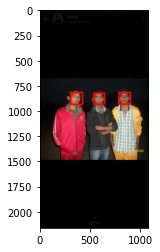

In [31]:
plt.imshow(images_with_detections[1])


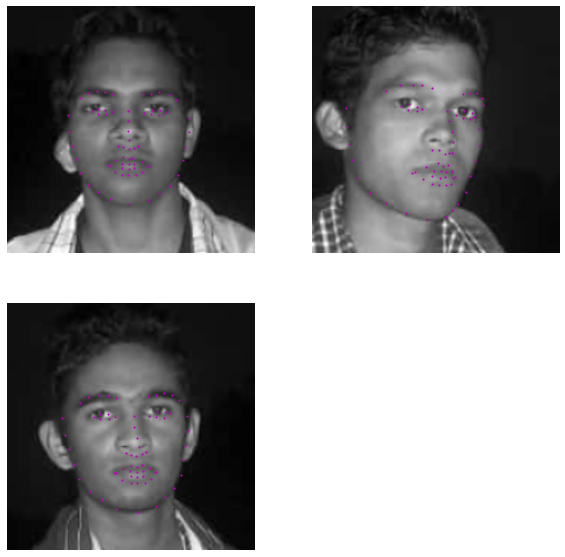

In [32]:
detect_keypoints(1,40,resnet18)

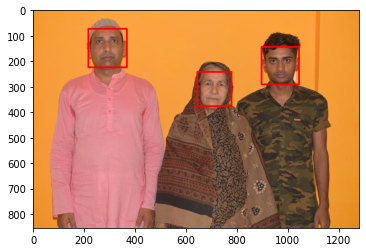

In [29]:
plt.imshow(images_with_detections[0])

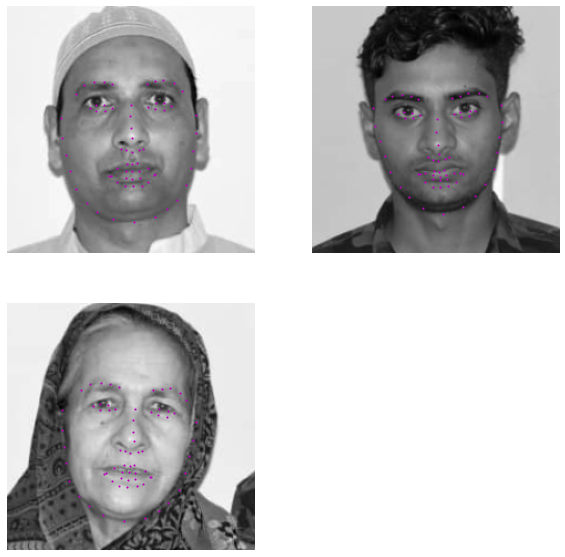

In [30]:
detect_keypoints(0,40,resnet18)